In [1]:
# Classic import
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = (14, 8)
import warnings
warnings.filterwarnings('ignore')

In [13]:
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix


def binary_classifiers_score(datasets, classifiers, cv=3,
                             scores=('accuracy', 'f1')):
    ret = list()
    for X, y in datasets:
        df = {}
        X = StandardScaler().fit_transform(X)
        for (name, clf) in classifiers.items():
            tmp = cross_validate(clf, X, y, scoring=scores, cv=cv, return_train_score=False)
            tmp = {key: round(val.mean(), 2) for key, val in tmp.items() if not key.endswith('time')}
            df[name] = pd.Series(tmp)
        ret.append(pd.DataFrame(df))

    return pd.concat(ret, keys=range(len(datasets)))

In [3]:
def binary_classifiers_plot(datasets, classifiers, meshsize=.02):
    n_rows = len(datasets)
    n_cols = len(classifiers) + 1
    fig, ax = plt.subplots(n_rows, n_cols,
                           figsize=(int(2.5*n_cols+1), int(2.5*n_rows+1)), squeeze=False)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    for i, (X, y) in enumerate(datasets):
        X = StandardScaler().fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=.4, random_state=42)

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, meshsize),
                             np.arange(y_min, y_max, meshsize))

        # Plot the scaled dataset
        if i == 0:
            ax[i, 0].set_title("Input data")
        # Plot the training points
        ax[i, 0].scatter(X_train[:, 0], X_train[:, 1],
                         c=y_train, cmap=cm_bright, edgecolors='k')
        # Plot the testing points
        ax[i, 0].scatter(X_test[:, 0], X_test[:, 1], c=y_test,
                         cmap=cm_bright, edgecolors='k', alpha=0.6)
        ax[i, 0].set_xlim(xx.min(), xx.max())
        ax[i, 0].set_ylim(yy.min(), yy.max())
        ax[i, 0].set_xticks(())
        ax[i, 0].set_yticks(())

        for j, (name, clf) in enumerate(classifiers.items()):
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax[i, j+1].contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot the training points
            ax[i, j+1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                               edgecolors='k')
            # Plot the testing points
            ax[i, j+1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                               edgecolors='k', alpha=0.6)

            ax[i, j+1].set_xlim(xx.min(), xx.max())
            ax[i, j+1].set_ylim(yy.min(), yy.max())
            ax[i, j+1].set_xticks(())
            ax[i, j+1].set_yticks(())
            ax[i, j+1].set_title(name)
            ax[i, j+1].text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                            size=15, horizontalalignment='right')

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

classifiers = {
    "Naive Bayes": GaussianNB(),
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", C=0.025),
    "RBF SVM": SVC(kernel="rbf", gamma=2, C=1),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Neural Net (MLP)": MLPClassifier(alpha=1),
    "AdaBoost": AdaBoostClassifier(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [5]:
from sklearn.datasets import make_moons, make_circles, make_classification
# Import the data here
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
]

In [14]:
binary_classifiers_score(datasets, classifiers, cv=3)

Naive Bayes  Nearest Neighbors  Linear SVM  RBF SVM  \
0 test_accuracy         0.85               0.95        0.85     0.93   
  test_f1               0.84               0.95        0.84     0.93   
1 test_accuracy         0.87               0.80        0.50     0.84   
  test_f1               0.86               0.81        0.60     0.84   
2 test_accuracy         0.95               0.93        0.94     0.93   
  test_f1               0.95               0.93        0.94     0.93   

                 Gaussian Process  Decision Tree  Random Forest  \
0 test_accuracy              0.95           0.88           0.89   
  test_f1                    0.95           0.87           0.89   
1 test_accuracy              0.87           0.75           0.78   
  test_f1                    0.87           0.77           0.78   
2 test_accuracy              0.92           0.89           0.91   
  test_f1                    0.92           0.89           0.91   

                 Neural Net (MLP)  AdaBoost   QDA  
0 test_accuracy              0.84      0.92  0.85  
  test_f1                    0.83      0.92  0.84  
1 test_accuracy              0.77      0.77  0.82  
  test_f1                    0.79      0.78  0.82  
2 test_accuracy              0.95      0.90  0.92  
  test_f1                    0.95      0.90  0.92

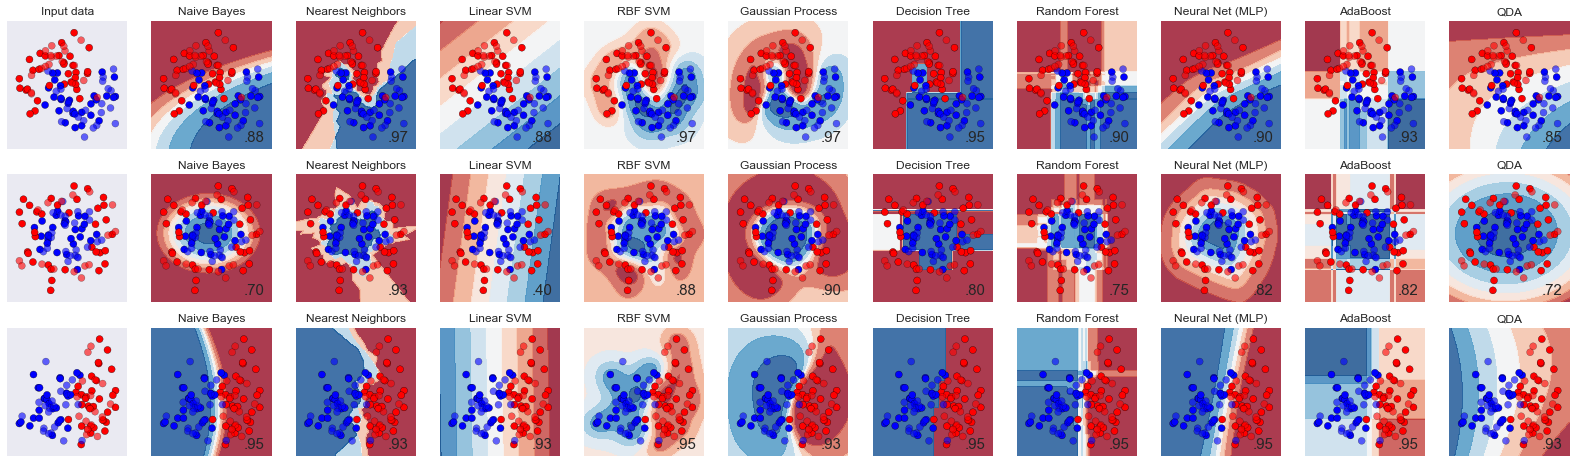

In [7]:
binary_classifiers_plot(datasets, classifiers)